# **Final Project - Part 2**
## Nick Bias
### 6/7/22
## **Goal: Use Speech Recognition to to conver human speech to written form**
### **Source** 
https://keras.io/examples/audio/ctc_asr/

## **Introduction** 
Speech recognition, also known as automatic speech recognition (ASR), computer speech recognition, or speech-to-text, is a capability which enables a program to process human speech into a written format. While it’s commonly confused with voice recognition, speech recognition focuses on the translation of speech from a verbal format to a text one whereas voice recognition just seeks to identify an individual user’s voice. 
(https://www.ibm.com/cloud/learn/speech-recognition)


In this Tutorial, we will be utilizing the LJSpeech dataset from the LibriVox project. It consists of short audio clips of a single speaker reading passages from 7 non-fiction books. This will show you how to combine 2-D Convolutional Neural Network (CNN), Recurrent Neural Network (RNN),  a Connectionist Temporal Classification (CTC) loss to build an ASR. CTC is an type of algorithm used to train deep neural networks in speech recognition, handwriting recognition and other sequence problems. CTC is used when we don’t know how the input aligns with the output (how the characters in the transcript align to the audio). 

We will then evaluate the model using Word Error Rate (WER) which will be explained more later. However, to get the WER score, you will need to install the jiwer library. 

In [ ]:
# used to get WER score
pip install jiwer

SyntaxError: ignored

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from IPython import display
from jiwer import wer

## **Load the Data**
The LJSpeech Dataset contains 13,100 audio files as wav files. The label (transcript) for each audio file is a string given in the metadata.csv file. Each audio file is a single-channel 16-bit PCM WAV with a sample rate of 22,050 Hz.

This dataset includes:
- ID: this is the name of the corresponding .wav file
- Transcription: words spoken by the reader (UTF-8)
- Normalized transcription: transcription with numbers, ordinals, and monetary units expanded into full words (UTF-8)
In terms of this tutorial, we will be using the "Normalized transcription" field. 

In [ ]:
data_url = "https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2"
data_path = keras.utils.get_file("LJSpeech-1.1", data_url, untar=True)
wavs_path = data_path + "/wavs/"
metadata_path = data_path + "/metadata.csv"


# Read metadata file and parse it
metadata_df = pd.read_csv(metadata_path, sep="|", header=None, quoting=3)
metadata_df.columns = ["file_name", "transcription", "normalized_transcription"]
metadata_df = metadata_df[["file_name", "normalized_transcription"]]
metadata_df = metadata_df.sample(frac=1).reset_index(drop=True)
metadata_df.head(3)

,file_name,normalized_transcription
0,LJ049-0063,Beyond these two principles the Secret Service...
1,LJ009-0122,particularly to those who desire now to offer ...
2,LJ023-0022,Today we are only part-way through that program


Since this audio data is so massive, it will be incredibly hard for the model to train on such a large set in a small amount of time. This is why we are going to limit the amount of file that will be used for this model. This may result in a less accurate model, but we are only trying to demonstrate how it works here. We will limit the dataset to just a quarter of its size. So instead of 13,100 audio files, there will be 3,275. From there we will do a 80-20 split for the training and testing data. 

In [ ]:
# Splitting the dataset into a Training and Testing set
#split = int(len(metadata_df) * 0.80)
# limiting the dataset to decrease model run time 
df_train = metadata_df[:2620]
df_val = metadata_df[2621:3275]

print(f"Size of the training set: {len(df_train)}")
print(f"Size of the training set: {len(df_val)}")

Size of the training set: 2620
Size of the training set: 654


## **Preprocessing**
In order to start Speech Recognition, we must first perpare the vocabulary to be used. 

In [ ]:
# The set of characters accepted in the transcription.
characters = [x for x in "abcdefghijklmnopqrstuvwxyz'?! "]
# Mapping characters to integers
char_to_num = keras.layers.StringLookup(vocabulary=characters, oov_token="")
# Mapping integers back to original characters
num_to_char = keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', ' '] (size =31)


The vocabulary that we will be using is the English Alphabet, as all the audio data is in English.

## Explanation 

Next, we will need to create a function that can transform each element of our dataset. The big difficulty when starting with sound data is that, unlike tabular data or images, sound data is not easy to represent in a tabular format.

As you may or may not know, images can be easily represented as matrices, because they are based on pixels. Each of the pixels has a value that indicates the intensity of the black and white (or for color images you have an intensity of red, green, and blue separately).

Sound, on the other hand, is a much more complex data format to work with:
- Sound is a mix of wave frequencies at different intensities. It is necessary to do a conversion into some sort of tabular or matrix-like data set before doing any machine learning.
- Secondly, sound has a time factor. It actually more comparable to video data than to image, as you have sound fragments of a certain duration rather than a capture at just one single point in time.

We will first need to cut all the audio files into equally long pieces. The next step of our sound preparation is the conversion into melspectrograms. Spectrograms are created using a Fourier Transform. In short, Fourier Transforms isolate different sound frequencies that are present in a sound, and resumes them in a strength-per-frequency-matrix, which we call a spectrogram. 
(https://towardsdatascience.com/machine-learning-on-sound-and-audio-data-3ae03bcf5095)

In [ ]:
# An integer scalar Tensor. The window length in samples.
frame_length = 256
# An integer scalar Tensor. The number of samples to step.
frame_step = 160
# An integer scalar Tensor. The size of the Fast Fourier Transform (FFT) to apply.
# If not provided, uses the smallest power of 2 enclosing frame_length.
fft_length = 384


def encode_single_sample(wav_file, label):
    ##  Process the Audio

    # 1. Read wav file
    file = tf.io.read_file(wavs_path + wav_file + ".wav")
    # 2. Decode the wav file
    audio, _ = tf.audio.decode_wav(file)
    audio = tf.squeeze(audio, axis=-1)
    # 3. Change type to float
    audio = tf.cast(audio, tf.float32)
    # 4. Get the spectrogram
    spectrogram = tf.signal.stft(
        audio, frame_length=frame_length, frame_step=frame_step, fft_length=fft_length
    )
    # 5. We only need the magnitude, which can be derived by applying tf.abs
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.math.pow(spectrogram, 0.5)
    # 6. normalisation
    means = tf.math.reduce_mean(spectrogram, 1, keepdims=True)
    stddevs = tf.math.reduce_std(spectrogram, 1, keepdims=True)
    spectrogram = (spectrogram - means) / (stddevs + 1e-10)

    ##  Process the label

    # 7. Convert label to Lower case
    label = tf.strings.lower(label)
    # 8. Split the label
    label = tf.strings.unicode_split(label, input_encoding="UTF-8")
    # 9. Map the characters in label to numbers
    label = char_to_num(label)
    # 10. Return a dict as our model is expecting two inputs
    return spectrogram, label

## **Creating Dataset objects**
We create a tf.data.Dataset object that yields the transformed elements, in the same order as they appeared in the input.

In [ ]:
batch_size = 45
# Define the trainig dataset
train_dataset = tf.data.Dataset.from_tensor_slices(
    (list(df_train["file_name"]), list(df_train["normalized_transcription"]))
)
train_dataset = (
    train_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

# Define the validation dataset
validation_dataset = tf.data.Dataset.from_tensor_slices(
    (list(df_val["file_name"]), list(df_val["normalized_transcription"]))
)
validation_dataset = (
    validation_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

## **Visualize the Data**
We can visualize an example in our dataset, including the audio clip, the spectrogram and the corresponding label.

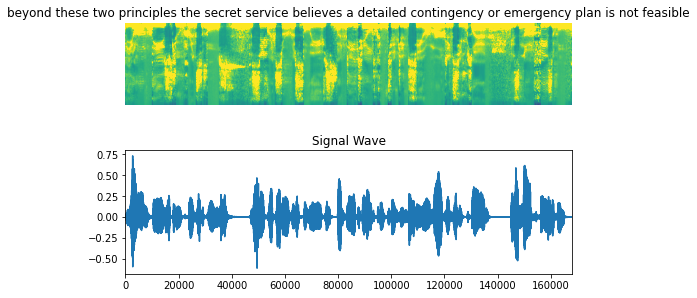

In [ ]:
fig = plt.figure(figsize=(8, 5))
for batch in train_dataset.take(1):
    spectrogram = batch[0][0].numpy()
    spectrogram = np.array([np.trim_zeros(x) for x in np.transpose(spectrogram)])
    label = batch[1][0]
    # Spectrogram
    label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
    ax = plt.subplot(2, 1, 1)
    ax.imshow(spectrogram, vmax=1)
    ax.set_title(label)
    ax.axis("off")
    # Wav
    file = tf.io.read_file(wavs_path + list(df_train["file_name"])[0] + ".wav")
    audio, _ = tf.audio.decode_wav(file)
    audio = audio.numpy()
    ax = plt.subplot(2, 1, 2)
    plt.plot(audio)
    ax.set_title("Signal Wave")
    ax.set_xlim(0, len(audio))
    display.display(display.Audio(np.transpose(audio), rate=16000))
plt.show()

The Yellowish-Green image is the Spectrogram and the image below that are the sound waves of the audio file. 

## **Model**
We first need to define the CTC Loss function. A Connectionist Temporal Classification Loss, or CTC Loss, is designed for tasks where we need alignment between sequences, but where that alignment is difficult - e.g. aligning each character to its location in an audio file. It calculates a loss between a continuous (unsegmented) time series and a target sequence.
(https://paperswithcode.com/method/ctc-loss#:~:text=A%20Connectionist%20Temporal%20Classification%20Loss,series%20and%20a%20target%20sequence.)

In [ ]:
def CTCLoss(y_true, y_pred):
    # Compute the training-time loss value
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

Now we can define our Model, which will be similar to DeepSpeech2. DeepSpeech2 is a set of speech recognition models based on Baidu DeepSpeech2. The preprocessing part takes a raw audio waveform signal and converts it into a log-spectrogram of size (N_timesteps, N_frequency_features). N_timesteps depends on an original audio file’s duration, N_frequency_features can be assigned in the model’s configuration file as “num_audio_features” parameter. 
The Deep Neural Network (DNN) part produces a probability distribution P_t(c) over vocabulary characters c per each time step t. DeepSpeech2 is trained with CTC loss. Word Error Rate (WER) is the main evaluation metric. In order to get words out of a trained model one needs to use a decoder. Decoder converts a probability distribution over characters into text.(https://nvidia.github.io/OpenSeq2Seq/html/speech-recognition/deepspeech2.html)

In [ ]:
def build_model(input_dim, output_dim, rnn_layers=5, rnn_units=128):
    """Model similar to DeepSpeech2."""
    # Model's input
    input_spectrogram = layers.Input((None, input_dim), name="input")
    # Expand the dimension to use 2D CNN.
    x = layers.Reshape((-1, input_dim, 1), name="expand_dim")(input_spectrogram)
    # Convolution layer 1
    x = layers.Conv2D(
        filters=32,
        kernel_size=[11, 41],
        strides=[2, 2],
        padding="same",
        use_bias=False,
        name="conv_1",
    )(x)
    x = layers.BatchNormalization(name="conv_1_bn")(x)
    x = layers.ReLU(name="conv_1_relu")(x)
    # Convolution layer 2
    x = layers.Conv2D(
        filters=32,
        kernel_size=[11, 21],
        strides=[1, 2],
        padding="same",
        use_bias=False,
        name="conv_2",
    )(x)
    x = layers.BatchNormalization(name="conv_2_bn")(x)
    x = layers.ReLU(name="conv_2_relu")(x)
    # Reshape the resulted volume to feed the RNNs layers
    x = layers.Reshape((-1, x.shape[-2] * x.shape[-1]))(x)
    # RNN layers
    for i in range(1, rnn_layers + 1):
        recurrent = layers.GRU(
            units=rnn_units,
            activation="tanh",
            recurrent_activation="sigmoid",
            use_bias=True,
            return_sequences=True,
            reset_after=True,
            name=f"gru_{i}",
        )
        x = layers.Bidirectional(
            recurrent, name=f"bidirectional_{i}", merge_mode="concat"
        )(x)
        if i < rnn_layers:
            x = layers.Dropout(rate=0.5)(x)
    # Dense layer
    x = layers.Dense(units=rnn_units * 2, name="dense_1")(x)
    x = layers.ReLU(name="dense_1_relu")(x)
    x = layers.Dropout(rate=0.5)(x)
    # Classification layer
    output = layers.Dense(units=output_dim + 1, activation="softmax")(x)
    # Model
    model = keras.Model(input_spectrogram, output, name="DeepSpeech_2")
    # Optimizer
    opt = keras.optimizers.Adam(learning_rate=1e-4)
    # Compile the model and return
    model.compile(optimizer=opt, loss=CTCLoss)
    return model


# Get the model
model = build_model(
    input_dim=fft_length // 2 + 1,
    output_dim=char_to_num.vocabulary_size(),
    rnn_units=512,
)
model.summary(line_length=110)

Model: "DeepSpeech_2"
______________________________________________________________________________________________________________
 Layer (type)                                    Output Shape                                Param #          
 input (InputLayer)                              [(None, None, 193)]                         0                
                                                                                                              
 expand_dim (Reshape)                            (None, None, 193, 1)                        0                
                                                                                                              
 conv_1 (Conv2D)                                 (None, None, 97, 32)                        14432            
                                                                                                              
 conv_1_bn (BatchNormalization)                  (None, None, 97, 32)                     

## **Training and Evaluation**

We will evaluate the quality of the model using Word Error Rate (WER). WER is obtained by adding up the substitutions, insertions, and deletions that occur in a sequence of recognized words. Divide that number by the total number of words originally spoken. The result is the WER.

In [ ]:
# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0]
    # Iterate over the results and get back the text
    output_text = []
    for result in results:
        result = tf.strings.reduce_join(num_to_char(result)).numpy().decode("utf-8")
        output_text.append(result)
    return output_text


# A callback class to output a few transcriptions during training
class CallbackEval(keras.callbacks.Callback):
    """Displays a batch of outputs after every epoch."""

    def __init__(self, dataset):
        super().__init__()
        self.dataset = dataset

    def on_epoch_end(self, epoch: int, logs=None):
        predictions = []
        targets = []
        for batch in self.dataset:
            X, y = batch
            batch_predictions = model.predict(X)
            batch_predictions = decode_batch_predictions(batch_predictions)
            predictions.extend(batch_predictions)
            for label in y:
                label = (
                    tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
                )
                targets.append(label)
        wer_score = wer(targets, predictions)
        print("-" * 100)
        print(f"Word Error Rate: {wer_score:.4f}")
        print("-" * 100)
        for i in np.random.randint(0, len(predictions), 2):
            print(f"Target    : {targets[i]}")
            print(f"Prediction: {predictions[i]}")
            print("-" * 100)

Start of Training Process.

This will take a few hours to run

In [ ]:
# Define the number of iterations.
# for good model prediction 50 is a good number of epochs, but this takes a lot of time to run
epochs = 1
# Callback function to check transcription on the val set.
validation_callback = CallbackEval(validation_dataset)
# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[validation_callback],
)

59/59 [==============================] - ETA: 0s - loss: 378.9416  ----------------------------------------------------------------------------------------------------
Word Error Rate: 1.0000
----------------------------------------------------------------------------------------------------
Target    : as requiring evidence of a plan or conspiracy to injure the president
Prediction: 
----------------------------------------------------------------------------------------------------
Target    : the occasion was considered excellent by the conspirators for disposal of the whole cabinet at one blow
Prediction: 
----------------------------------------------------------------------------------------------------
59/59 [==============================] - 15798s 267s/step - loss: 378.9416 - val_loss: 359.9925


## **Inference** 

In [ ]:
# Let's check results on more validation samples
predictions = []
targets = []
for batch in validation_dataset:
    X, y = batch
    batch_predictions = model.predict(X)
    batch_predictions = decode_batch_predictions(batch_predictions)
    predictions.extend(batch_predictions)
    for label in y:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        targets.append(label)
wer_score = wer(targets, predictions)
print("-" * 100)
print(f"Word Error Rate: {wer_score:.4f}")
print("-" * 100)
for i in np.random.randint(0, len(predictions), 5):
    print(f"Target    : {targets[i]}")
    print(f"Prediction: {predictions[i]}")
    print("-" * 100)

----------------------------------------------------------------------------------------------------
Word Error Rate: 1.0000
----------------------------------------------------------------------------------------------------
Target    : the office of naval intelligence the fbi and the cia the information known to the fbi is summarized below
Prediction: 
----------------------------------------------------------------------------------------------------
Target    : first it must be noted that some structures are not nonadaptive that is do not change to fit changed habits or conditions of life
Prediction: 
----------------------------------------------------------------------------------------------------
Target    : and at length reached a point opposite the top of the building containing the condemned wards this had been a perilous and painful task
Prediction: 
----------------------------------------------------------------------------------------------------
Target    : it was still

This took a few hours to run and as we can see the Word Error Rate is 100%. This means that it is not able to recognize the speech at all. If we look at the predictions, we can see that the model is not predicting anything based on the audio. 

If we were to increase the Epochs to 50 and used the full dataset for testing and train, it would perform much better. This however, requires a very powerful computer to be able to process that much information. The model would also take a very long time to run. 